In [2]:
import warnings
warnings.filterwarnings('ignore')
# Never going to remove this again
# Annoying kaayo ang warning sa colab
# It's not even funny (-_-)

In [3]:
import os
import kagglehub
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model # Just something that can help with model vis
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# ---------------------
# 1.A. DOWNLOAD DATASET
# ---------------------
DATASET_PATH = "TrashType_Image_Dataset"   # Root dataset folder
path = kagglehub.dataset_download(
    "farzadnekouei/trash-type-image-dataset"
)

print("Dataset downloaded to:", path)
print("Folder contents:", os.listdir(path))

# Adjust this if needed
DATASET_PATH = os.path.join(path, "TrashType_Image_Dataset")
print("Dataset path to:", DATASET_PATH)

100%|██████████| 40.9M/40.9M [00:03<00:00, 13.2MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/farzadnekouei/trash-type-image-dataset/versions/1
Folder contents: ['TrashType_Image_Dataset']
Dataset path to: /root/.cache/kagglehub/datasets/farzadnekouei/trash-type-image-dataset/versions/1/TrashType_Image_Dataset


In [4]:
class_garbage_types = os.listdir(DATASET_PATH)
print(class_garbage_types)

['trash', 'plastic', 'paper', 'metal', 'glass', 'cardboard']


In [5]:
# ---------------------
# 1.B. Data Cleaning/Validation
# ---------------------
size_collection = set()

for garbage_class in class_garbage_types:
    folder_path = os.path.join(DATASET_PATH, garbage_class)

    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        image_count = len(image_files)
        print(f"{garbage_class} folder contains {image_count} images.")

        for image in image_files:
            path = os.path.join(folder_path, image)

            with Image.open(path) as img:
                width, height = img.size
                channels = len(img.getbands())
                size_collection.add((width, height, channels))

if len(size_collection) == 1:
    width, height, channel = size_collection.pop()
    print(f"\nAll pictures have the same sizes: {width}x{height} with {channels} color channels.")
else:
    print("\nThe given pictures have different sizes or color channels.")

trash folder contains 137 images.
plastic folder contains 482 images.
paper folder contains 594 images.
metal folder contains 410 images.
glass folder contains 501 images.
cardboard folder contains 403 images.

All pictures have the same sizes: 512x384 with 3 color channels.


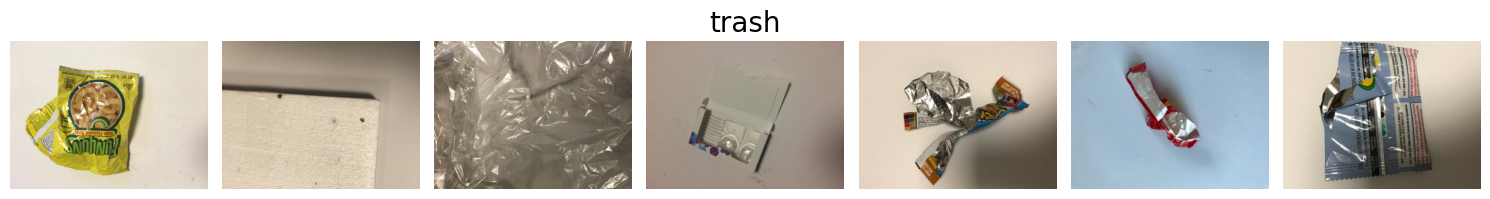

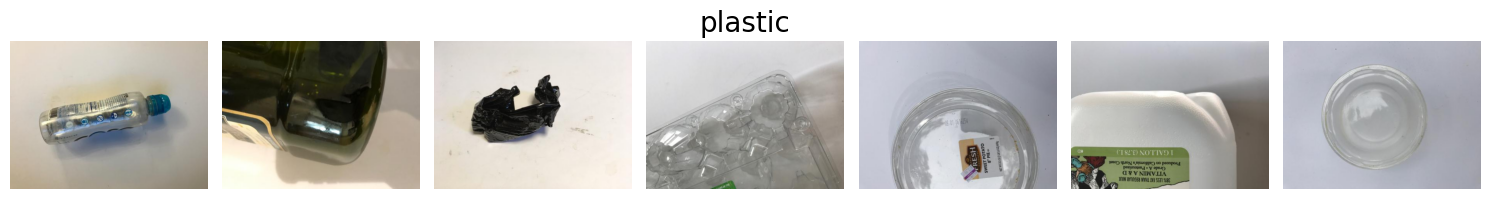

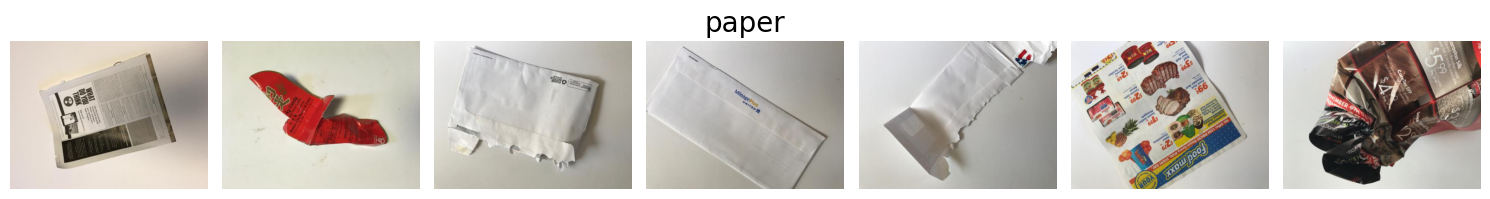

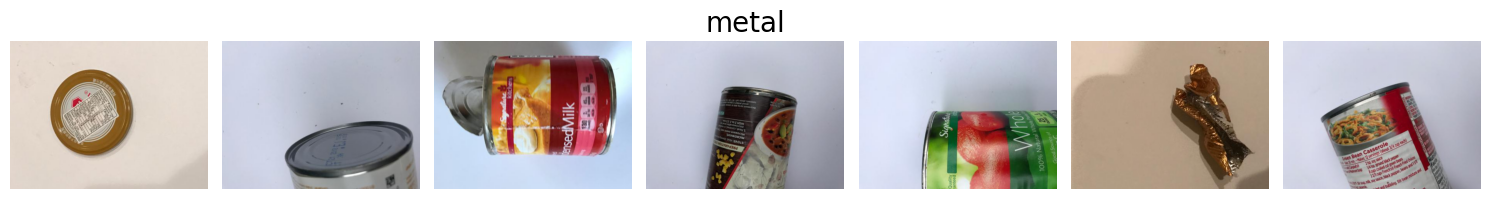

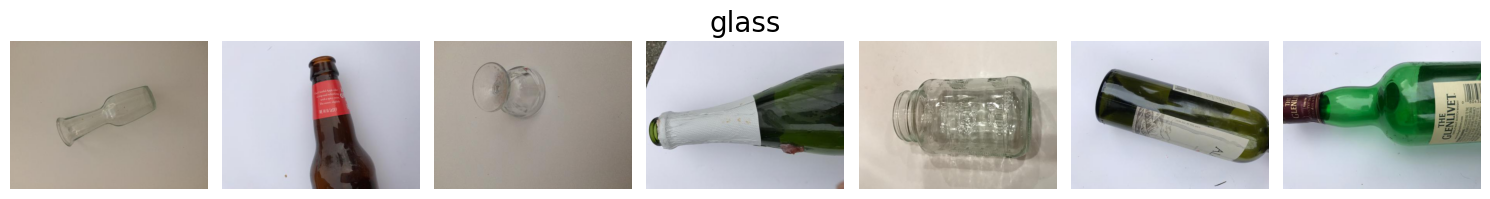

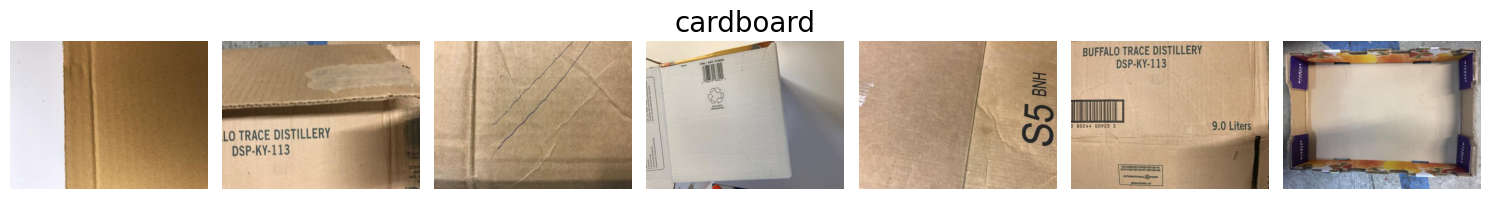

In [6]:
# Since there is a big imbalance on the given pictures we need to
# create an efficient classifier to address it.
for garbage_class in class_garbage_types:
    folder = os.path.join(DATASET_PATH, garbage_class)

    if os.path.isdir(folder):
          images = [f for f in os.listdir(folder) if f.endswith(('jpg', 'jpeg'))]
          images = images[:7]
          fig, axs = plt.subplots(1, 7, figsize=(15, 2))

          for i, image_file in enumerate(images):
              image = os.path.join(folder, image_file)

              with Image.open(image) as img:
                  axs[i].imshow(img)
                  axs[i].axis('off')

          plt.tight_layout()
          fig.suptitle(garbage_class, fontsize=20, y=1.03)
          plt.show()

In [7]:
import pandas as pd #dataframe

# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in class_garbage_types:
    for file in os.listdir(os.path.join(DATASET_PATH, garbage_type)): #go through every file inside that folder.
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(DATASET_PATH, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

filepath  label
0  /root/.cache/kagglehub/datasets/farzadnekouei/...  trash
1  /root/.cache/kagglehub/datasets/farzadnekouei/...  trash
2  /root/.cache/kagglehub/datasets/farzadnekouei/...  trash
3  /root/.cache/kagglehub/datasets/farzadnekouei/...  trash
4  /root/.cache/kagglehub/datasets/farzadnekouei/...  trash

In [8]:
# Split with stratification (ordered)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label']) #divides data — 80% for training, 20% for validation, keeping same class ratio(balance) in both sets.

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 2021
Number of images in the validation set: 506


In [9]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100 #calculates what percent of each trash type is in the full dataset.

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40) #separator-print a line for clarity.

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


In [10]:
# ---------------------
# 3. DATA GENERATORS
# ---------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,

    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations (tilt)
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
)

In [11]:
# ---------------------
# 2. CONFIG
# ---------------------
IMAGE_SIZE = (384, 384)
BATCH_SIZE = 32
NUM_CLASSES = 6

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=42,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=42,
    shuffle=False
)

print("Train Classes:", train_generator.class_indices)
print("Validator Classes:", val_generator.class_indices)

print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.
Train Classes: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Validator Classes: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [12]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [13]:
# ---------------------
# 4. CLASS WEIGHTS
# ---------------------
weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=train_df['label']
)

print(weights)

class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

[3.06212121 0.83998337 0.70912281 1.02693089 0.87489177 1.04606625]


{0: np.float64(3.062121212121212),
 1: np.float64(0.8399833748960931),
 2: np.float64(0.7091228070175438),
 3: np.float64(1.026930894308943),
 4: np.float64(0.8748917748917749),
 5: np.float64(1.0460662525879918)}

In [14]:
# ---------------------
# 5. BUILD RESNET MODEL
# ---------------------
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(384,384,3)
)

base_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 384, 384,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 384, 384,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 384, 384,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 385, 385,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 192, 192,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 192, 192,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 192, 192,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 192, 192,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 192, 192,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 192, 192,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 192, 192,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 192, 192,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [15]:
len(base_model.layers)

for i, layer in enumerate(base_model.layers):
    #if 140 <= i <= 150:
        print(i, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [16]:
for layer in base_model.layers[:163]:
    layer.trainable = False

In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

transfer_efficientnetb0_model = Model(inputs=base_model.input, outputs=output)

transfer_efficientnetb0_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

transfer_efficientnetb0_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 384, 384,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 384, 384,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 384, 384,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 385, 385,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 192, 192,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 192, 192,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 192, 192,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 192, 192,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 192, 192,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 192, 192,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 192, 192,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 192, 192,  │        512 │ block1a_se_excit

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 3,163,426 (12.07 MB)

 Non-trainable params: 893,831 (3.41 MB)

Architecture of the model using EfficientNetB0:

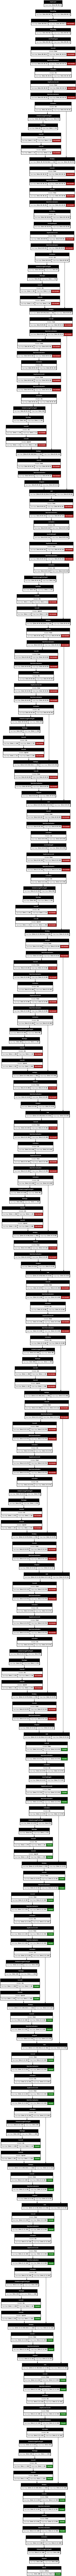

In [18]:
plot_model(
    transfer_efficientnetb0_model,
    show_shapes=True,
    show_layer_names=False,
    dpi=200,
    show_dtype=False,
    expand_nested=False,
    show_layer_activations=True,
    show_trainable=True
)

In [19]:
# ---------------------
# 6. TRAINING
# ---------------------
# Define the callbacks
checkpoint = ModelCheckpoint(
    "garbage_efficientnetb0.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

# Total number of epochs
num_epochs = 50

history = transfer_efficientnetb0_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weights, #using class weights
    callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3297 - loss: 1.8872
Epoch 1: val_accuracy improved from -inf to 0.71344, saving model to garbage_efficientnetb0.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.3317 - loss: 1.8814 - val_accuracy: 0.7134 - val_loss: 0.9320 - learning_rate: 1.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6942 - loss: 0.9199
Epoch 2: val_accuracy improved from 0.71344 to 0.78458, saving model to garbage_efficientnetb0.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6946 - loss: 0.9183 - val_accuracy: 0.7846 - val_loss: 0.5787 - learning_rate: 1.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8055 - loss: 0.6087
Epoch 3: val_accuracy improved from 0.78458 to 0.84980, saving model to garbage_efficientnetb0.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8057 - loss: 0.6080 - val_accuracy: 0.8498 - val_loss: 0.4228 - learning_rate: 1.0000e-04
Epoch 4/50
64/64 ━━━━

In [20]:
# ---------------------
# 7. SAVE MODEL
# ---------------------
transfer_efficientnetb0_model.save("garbage_classifier_final.keras")
print("Model saved successfully as 'garbage_classifier_final.keras'")

Model saved successfully as 'garbage_classifier_final.keras'


In [21]:
# ---------------------
# 8. VISUALIZATION
# ---------------------
import seaborn as sns #charts / data visualisation
from matplotlib.colors import LinearSegmentedColormap
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

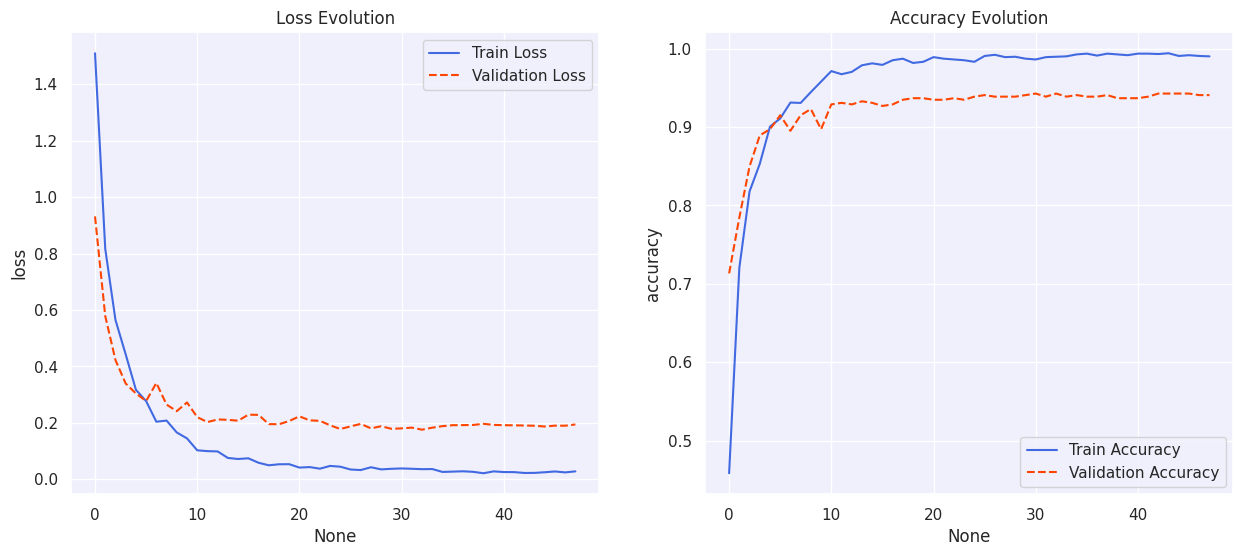

In [22]:
plot_learning_curves(history, start_epoch=1)

In [23]:
# ---------------------
# 9. PERFORMANCE TEST
# ---------------------
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 570ms/step
              precision    recall  f1-score   support

   cardboard       1.00      0.96      0.98        81
       glass       0.97      0.90      0.93       100
       metal       0.87      0.98      0.92        82
       paper       0.95      0.97      0.96       119
     plastic       0.95      0.94      0.94        97
       trash       0.88      0.81      0.85        27

    accuracy                           0.94       506
   macro avg       0.94      0.93      0.93       506
weighted avg       0.94      0.94      0.94       506





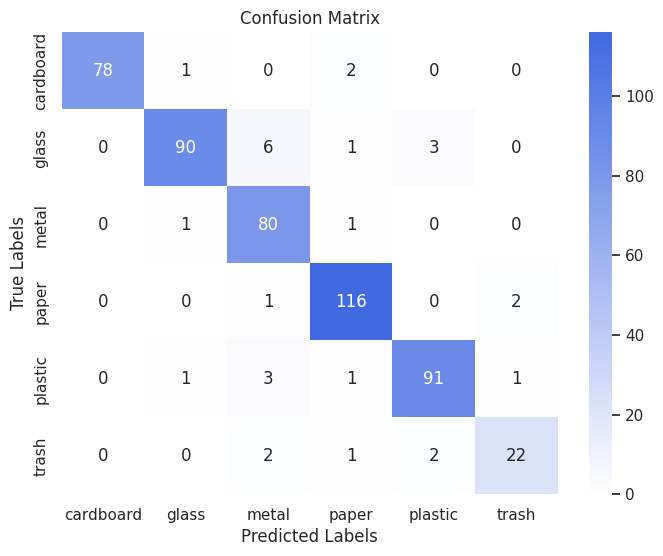

In [24]:
evaluate_model_performance(
    transfer_efficientnetb0_model,
    val_generator,
    class_labels
)

### Model Performance Inferences:
1. **Overall Accuracy**: The EfficientNetB0 model boasts an accuracy of **94%**, almost near the result of a *ResNet50* model that got a **95%**.
2. **Weighter Avg. F1 score**: **94%**
3. **Cardboard**, **Glass**, **Metal**, **Paper**, and **Plastic** are standout performers, demonstrating near-perfect results.
4. **Trash** has also put up strong performances although compared to the ResNet50 model, there is a boost in precision but a little degrade on recall.
5. **Consistent F1-scores** across categories highlight the mode's reliability in making balanced predictions.